# Practice Session PS05: Recommendation engines (Content-based)

<font size="+2" color="blue">Additional results: tags</font>

Author: <font color="blue">Manvir Kaur Singh</font>

E-mail: <font color="blue">manvir.kaur01@estudiant.upf.edu</font>

Date: <font color="blue">15/11/2023</font>

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd   
import numpy as np  
import re
import matplotlib.pyplot as plt  
from math import*
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

In [3]:
# Leave this code as-is

FILENAME_MOVIES = "movies-2000s.csv"
FILENAME_RATINGS = "ratings-2000s.csv"
FILENAME_TAGS = "tags-2000s.csv"


In [4]:
# Leave this code as-is

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep=',', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
display(movies.head(5))

ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep=',', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating'])
display(ratings_raw.head(5))

tags = pd.read_csv(FILENAME_TAGS, 
                    sep=',', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'tag', 'time_stamp'])
display(tags.head(5))


,movie_id,title,genres
0,2769,"Yards, The (2000)",Crime|Drama
1,3177,Next Friday (2000),Comedy
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
3,3225,Down to You (2000),Comedy|Romance
4,3228,Wirey Spindell (2000),Comedy


,user_id,movie_id,rating
0,4,1,3.0
1,4,260,3.5
2,4,296,4.0
3,4,541,4.5
4,4,589,4.0


,user_id,movie_id,tag,time_stamp
0,4,44665,unreliable narrators,1573943619
1,68,3481,music,1472113217
2,91,3481,based on a book,1399117141
3,91,3481,break-up,1399117159
4,91,3481,Catherine Zeta-Jones,1399117136


In [5]:
def yearof(title):
    match = re.search(r'\((\d{4})\)', title)
    if match:
        year = match.group(1)  
        return int(year)
    else:
        return None
 
    
print(yearof("The Emoji Movie (2017)"))   

2017


In [6]:
movies['Year'] = movies.apply(lambda x: yearof(x['title']), axis=1)
    
print(movies)

       movie_id                       title                     genres  Year
0          2769           Yards, The (2000)                Crime|Drama  2000
1          3177          Next Friday (2000)                     Comedy  2000
2          3190            Supernova (2000)  Adventure|Sci-Fi|Thriller  2000
3          3225          Down to You (2000)             Comedy|Romance  2000
4          3228       Wirey Spindell (2000)                     Comedy  2000
...         ...                         ...                        ...   ...
33163    209155  Santosh Subramaniam (2008)      Action|Comedy|Romance  2008
33164    209157                   We (2018)                      Drama  2018
33165    209159   Window of the Soul (2001)                Documentary  2001
33166    209163            Bad Poems (2018)               Comedy|Drama  2018
33167    209169         A Girl Thing (2001)         (no genres listed)  2001

[33168 rows x 4 columns]


<font size="+1" color="red">Brief commentary indicating on which field you can join ratings_raw and users, and on which field you can join ratings_raw and movies.</font>

ratings_raw with user --> user_id

rating_raw with movies --> movie_id

In [7]:
ratings = pd.merge(movies, ratings_raw, how='inner', on='movie_id')
display(ratings)

,movie_id,title,genres,Year,user_id,rating
0,2769,"Yards, The (2000)",Crime|Drama,2000,1115,4.0
1,2769,"Yards, The (2000)",Crime|Drama,2000,1209,2.0
2,2769,"Yards, The (2000)",Crime|Drama,2000,2004,3.0
3,2769,"Yards, The (2000)",Crime|Drama,2000,2502,4.0
4,2769,"Yards, The (2000)",Crime|Drama,2000,2827,4.0
...,...,...,...,...,...,...
472966,33166,Crash (2004),Crime|Drama,2004,162193,5.0
472967,33166,Crash (2004),Crime|Drama,2004,162196,4.5
472968,33166,Crash (2004),Crime|Drama,2004,162245,5.0
472969,33166,Crash (2004),Crime|Drama,2004,162533,4.0


In [8]:
def find_movies(word, movies):
    for index, row in movies.iterrows():
        if word in row['title']:
            print("movie_id: ", row['movie_id'], "title: ", row['title'])

find_movies("Friday", movies)

movie_id:  3177 title:  Next Friday (2000)
movie_id:  5874 title:  Friday After Next (2002)
movie_id:  6593 title:  Freaky Friday (2003)
movie_id:  7880 title:  Friday Night (Vendredi Soir) (2002)
movie_id:  8937 title:  Friday Night Lights (2004)
movie_id:  66783 title:  Friday the 13th (2009)
movie_id:  97175 title:  His Name Was Jason: 30 Years of Friday the 13th (2009)
movie_id:  121113 title:  Shriek If You Know What I Did Last Friday the Thirteenth (2000)
movie_id:  133699 title:  Black Friday (2004)
movie_id:  134649 title:  Bad Hair Friday (2012)
movie_id:  161157 title:  Friday (Pyatnitsa) (2016)
movie_id:  171951 title:  Monster High: Friday Night Frights (2013)
movie_id:  192411 title:  Freaky Friday (2018)
movie_id:  197903 title:  Seven Days: Friday - Sunday (2015)


# 2. Exploratory Data Analysis

## 2.1. "Rating" variable

In [9]:
# Leave this code as-is
ratings['rating'].describe()

count    472971.000000
mean          3.462222
std           1.076063
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

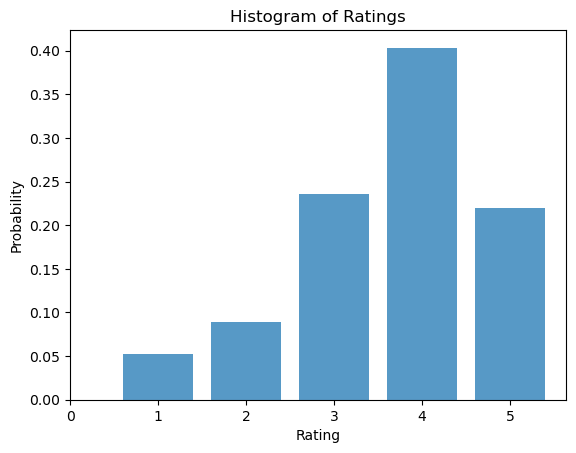

In [10]:
bins = [0, 1, 2, 3, 4, 5]

ratings['binned_ratings'] = np.digitize(ratings['rating'], bins, right=True)
hist_data = ratings['binned_ratings'].value_counts(normalize=True).sort_index()

# Plot the histogram
plt.bar(hist_data.index, hist_data.values, align='center', alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Probability')
plt.xticks(range(6))
plt.title('Histogram of Ratings')
plt.show()

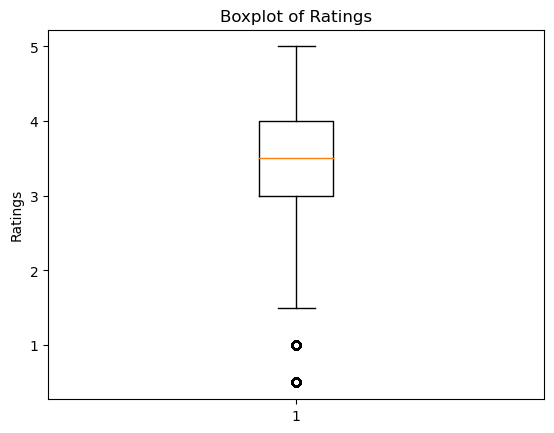

In [11]:
plt.boxplot(ratings['rating'])
plt.ylabel('Ratings')
plt.title('Boxplot of Ratings')
plt.show()

<font size="+1" color="red">Brief commentary on what you observe in the distribution of ratings.</font>

We can see a left-skewed distibution centered around 4. And from the boxplot we can see 2 outliers which are 0 and 1 ratings.

<font size="+1" color="red">Replace this cell with code to print the 10 movies with the most "good" ratings (i.e., ratings that are larger than 4.0), and the 10 movies with the most "bad" ratings (i.e., ratings than are smaller than 2.0)</font>

In [12]:
good_ratings =  ratings[ratings['rating'] > 4.0]
bad_ratings =  ratings[ratings['rating'] < 2.0]




In [13]:
good_ratings.head(10)

,movie_id,title,genres,Year,user_id,rating,binned_ratings
11,2769,"Yards, The (2000)",Crime|Drama,2000,18628,5.0,5
42,2769,"Yards, The (2000)",Crime|Drama,2000,63014,5.0,5
45,2769,"Yards, The (2000)",Crime|Drama,2000,67394,5.0,5
48,2769,"Yards, The (2000)",Crime|Drama,2000,77472,5.0,5
85,2769,"Yards, The (2000)",Crime|Drama,2000,131418,5.0,5
123,3177,Next Friday (2000),Comedy,2000,25008,5.0,5
129,3177,Next Friday (2000),Comedy,2000,32211,4.5,5
140,3177,Next Friday (2000),Comedy,2000,42513,5.0,5
146,3177,Next Friday (2000),Comedy,2000,48199,5.0,5
148,3177,Next Friday (2000),Comedy,2000,50524,5.0,5


In [14]:
bad_ratings.head(10)

,movie_id,title,genres,Year,user_id,rating,binned_ratings
5,2769,"Yards, The (2000)",Crime|Drama,2000,6629,1.0,1
55,2769,"Yards, The (2000)",Crime|Drama,2000,84020,1.0,1
67,2769,"Yards, The (2000)",Crime|Drama,2000,106833,1.0,1
96,2769,"Yards, The (2000)",Crime|Drama,2000,155853,1.0,1
113,3177,Next Friday (2000),Comedy,2000,10336,0.5,1
115,3177,Next Friday (2000),Comedy,2000,11952,1.0,1
116,3177,Next Friday (2000),Comedy,2000,13915,1.0,1
117,3177,Next Friday (2000),Comedy,2000,14273,1.0,1
122,3177,Next Friday (2000),Comedy,2000,23223,1.0,1
125,3177,Next Friday (2000),Comedy,2000,28678,1.0,1


<font size="+1" color="red">Brief commentary on what you observe in these lists.</font>

I can see that the same movies appear in both ratings, that can be because those are popular movies, which means more people can give ratings.

## 2.2. Genres distribution

In [15]:
all_genres = set()
for genres_list in movies['genres']:
    genres = genres_list.split('|')
    all_genres.update(genres)

print("List of all genres:")
print(list(all_genres))

assert len(all_genres) == 20, "Number of genres is not 20"

List of all genres:
['IMAX', 'Fantasy', 'Children', 'Musical', 'Film-Noir', 'Crime', 'Horror', 'Action', 'Drama', 'Documentary', 'Animation', 'Thriller', 'Western', 'War', 'Comedy', 'Mystery', 'Romance', 'Adventure', '(no genres listed)', 'Sci-Fi']


In [16]:
genres_series = movies['genres'].str.split('|', expand=True).stack()
keyword_occurences = genres_series.value_counts()

frequencies = (genres_series.value_counts())
genres_list = frequencies.reset_index().values.tolist()
for genre in genres_list:
    print(genre)


['Drama', 13666]
['Comedy', 8898]
['Thriller', 5437]
['Documentary', 4473]
['Action', 3901]
['Romance', 3846]
['Horror', 3431]
['Crime', 2425]
['(no genres listed)', 2200]
['Sci-Fi', 1907]
['Adventure', 1906]
['Children', 1639]
['Animation', 1553]
['Mystery', 1516]
['Fantasy', 1456]
['War', 679]
['Musical', 308]
['Western', 194]
['IMAX', 173]
['Film-Noir', 21]


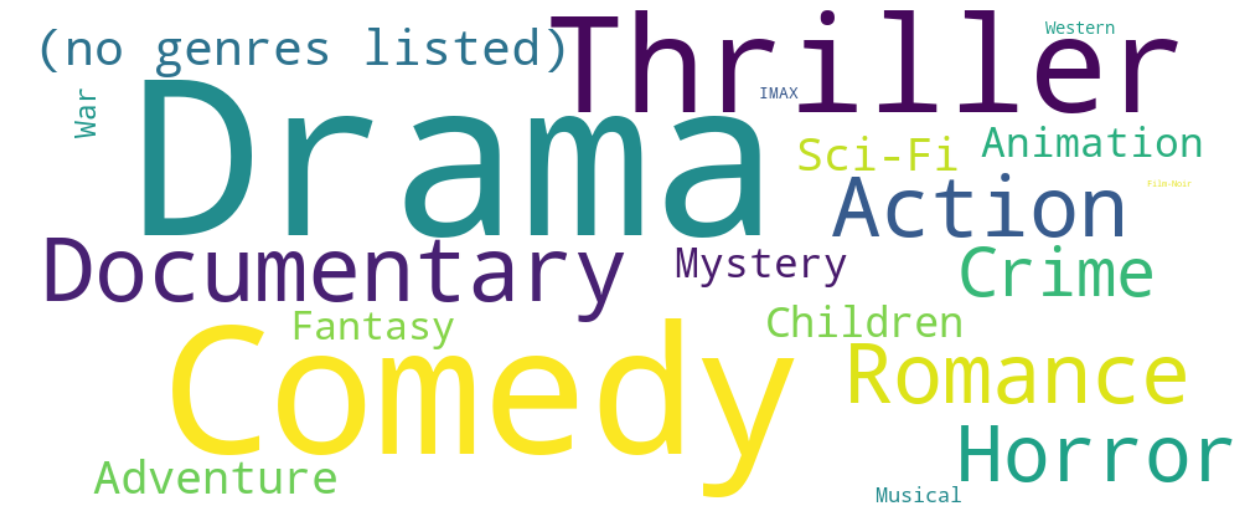

In [17]:
# Change the colors/style if you want

# Generate the word cloud
genre_wordcloud = WordCloud(width=1000, height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(dict(keyword_occurences))

# Plot the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

BEFORE 2010


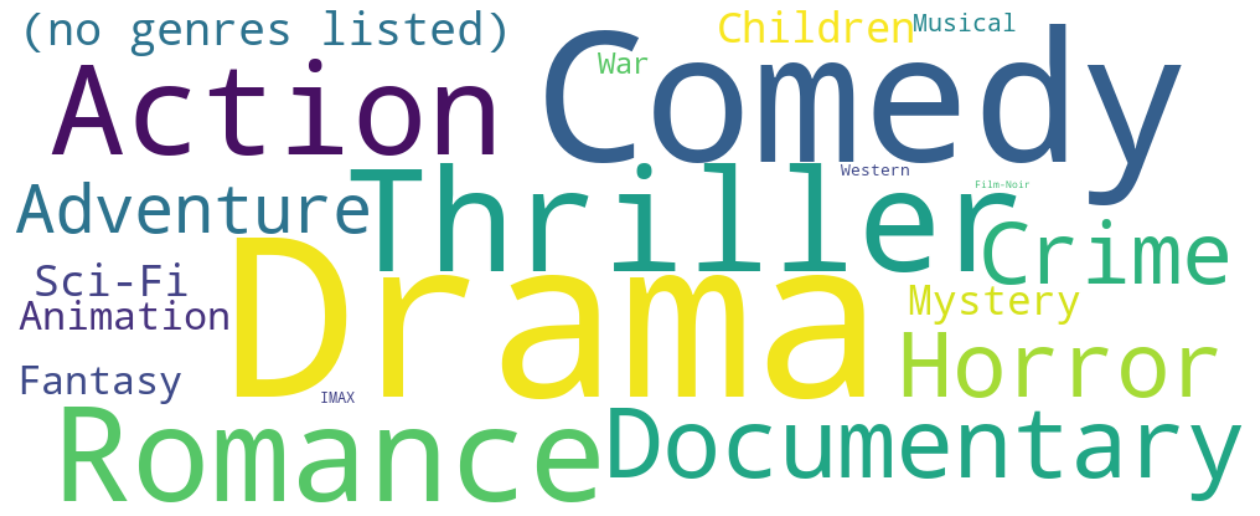

AFTER 2010


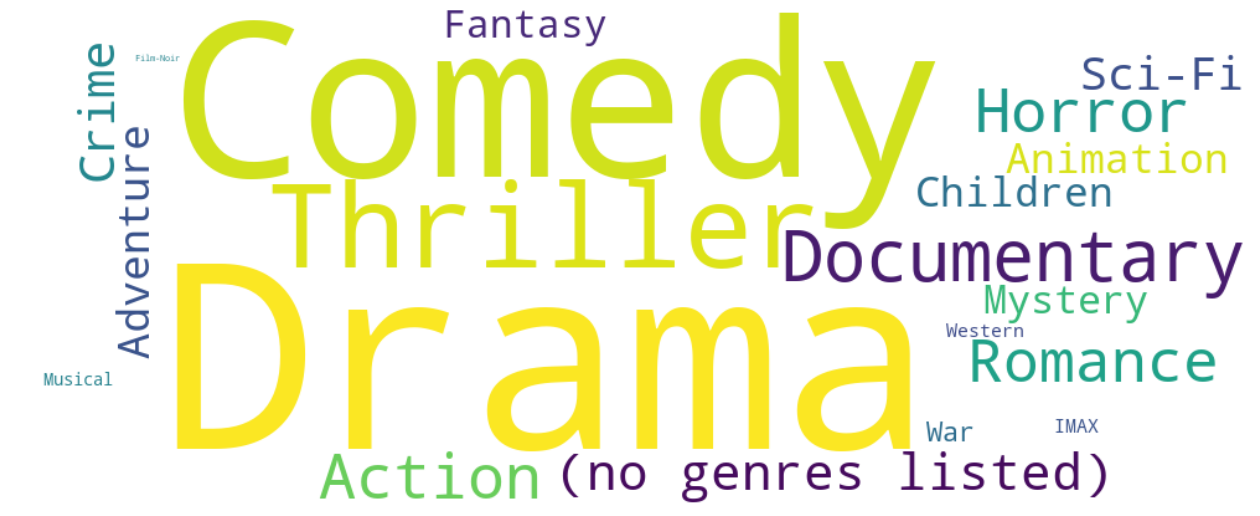

In [18]:
condition1 = movies['Year'] < 2010
condition2 = movies['Year'] >= 2010
genres_split_before2010 = movies[condition1]['genres'].str.split('|', expand=True).stack()
genres_split_after2010 = movies[condition2]['genres'].str.split('|', expand=True).stack()
frequencies_before2010 = (genres_split_before2010.value_counts())
frequencies_after2010 = (genres_split_after2010.value_counts())
genres_list_before2010 = frequencies_before2010.reset_index().values.tolist()
genres_list_after2010 = frequencies_after2010.reset_index().values.tolist()


print("BEFORE 2010")
# Change the colors/style if you want

# Generate the word cloud
genre_wordcloud = WordCloud(width=1000, height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(dict(genres_list_before2010))

# Plot the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("AFTER 2010")

# Generate the word cloud
genre_wordcloud = WordCloud(width=1000, height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(dict(genres_list_after2010))

# Plot the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Movies after 2010, thriller, romance and action genres lost a bit of significance. 

# 3. Content-based recommendation

## 3.1. Compute TF-IDF vectors

In [19]:
movies['genres_arr'] = movies['genres'].str.split('|').fillna('').astype('str')


In [20]:
# Leave this code as-is

print("Transformed: %s → %s" % (movies['genres'][3], movies['genres_arr'][3]))

Transformed: Comedy|Romance → ['Comedy', 'Romance']


In [21]:
# LEAVE AS-IS

# The reset-index is important to match row/column numbers in the tdifd-matrix

movies_filtered = movies[movies.Year > 2015]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered.head(5))

,index,movie_id,title,genres,Year,genres_arr
0,10897,122888,Ben-hur (2016),(no genres listed),2016,['(no genres listed)']
1,10898,122890,Warcraft (2016),Action|Adventure|Fantasy,2016,"['Action', 'Adventure', 'Fantasy']"
2,10900,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),2017,['(no genres listed)']
3,10901,122898,Justice League (2017),Action|Adventure|Sci-Fi,2017,"['Action', 'Adventure', 'Sci-Fi']"
4,10904,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi,2016,"['Action', 'Adventure', 'Comedy', 'Sci-Fi']"


In [22]:
#genres_strings = movies_filtered['genres_arr'].apply(lambda x: ', '.join(eval(x)))

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

tfidf_matrix = tfidf_vectorizer.fit_transform(movies_filtered['genres_arr'])

print("Shape of tfidf_matrix:", tfidf_matrix.shape)

Shape of tfidf_matrix: (7890, 130)


## 3.2. Calculate most similar movies

In [23]:
# Leave this code as-is

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.         1.         ... 1.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [1.         0.         1.         ... 1.         0.         0.        ]
 ...
 [1.         0.         1.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.41022264]
 [0.         0.         0.         ... 0.         0.41022264 1.        ]]


In [24]:
# Leave this code as-is

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies_filtered.iloc[index_target].movie_id, movies_filtered.iloc[index_target].title))
        
print_similarity_vector(122904, cosine_sim)



0.000 122888 Ben-hur (2016)
0.362 122890 Warcraft (2016)
0.000 122896 Pirates of the Caribbean: Dead Men Tell No Tales (2017)
0.600 122898 Justice League (2017)
1.000 122904 Deadpool (2016)
0.600 122906 Black Panther (2017)
0.600 122908 Inhumans (2018)
0.600 122910 Captain Marvel (2018)
0.600 122912 Avengers: Infinity War - Part I (2018)
0.600 122914 Avengers: Infinity War - Part II (2019)
0.600 122916 Thor: Ragnarok (2017)
0.600 122918 Guardians of the Galaxy 2 (2017)
0.359 122920 Captain America: Civil War (2016)
0.600 122922 Doctor Strange (2016)
0.504 122924 X-Men: Apocalypse (2016)
0.362 122926 Untitled Spider-Man Reboot (2017)
0.440 135141 Allegiant: Part 1 (2016)
0.000 135143 Fantastic Beasts and Where to Find Them (2016)
0.000 135426 Fantastic Beasts and Where to Find Them 2 (2018)
0.056 135436 The Secret Life of Pets (2016)
0.326 135530 Criminal (2016)
0.309 135536 Suicide Squad (2016)
0.600 135567 Independence Day: Resurgence (2016)
0.600 135569 Star Trek Beyond (2016)
0.000 

In [25]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]
    
    sim_scores = list(similarities[index_source])
    enumerated = list(enumerate(sim_scores))
    sorted_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
    top_similarities = sorted_similarities[0:num_movies]
    
    recommendations = []
    for (index_target, similarity) in top_similarities:
        
        # Replace this comment with code to obtain movie_id, title, genres
        title = (movies.iloc[index_target])['title']
        genres = (movies.iloc[index_target])['genres']
        movie_id = (movies.iloc[index_target])['movie_id']
        
        recommendations.append({
                'movie_id': movie_id,
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )
    
    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])

In [26]:
#similarities = print_similarity_vector(122896, cosine_sim)

In [27]:
#movies or

genre_content_based_recommendations(122896, movies_filtered, cosine_sim, num_movies=10)

,similarity,movie_id,title,genres
0,1.0,122888,Ben-hur (2016),(no genres listed)
1,1.0,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed)
2,1.0,135426,Fantastic Beasts and Where to Find Them 2 (2018),(no genres listed)
3,1.0,138212,Spectral (2016),(no genres listed)
4,1.0,141131,Guardians (2016),(no genres listed)
5,1.0,143387,Pitch Perfect 3 (2017),(no genres listed)
6,1.0,150724,Army Dog (2016),(no genres listed)
7,1.0,151461,Fitoor (2016),(no genres listed)
8,1.0,151593,Martyrs (2016),(no genres listed)
9,1.0,152037,Grease Live (2016),(no genres listed)


In [28]:
genre_content_based_recommendations(201646, movies_filtered, cosine_sim, num_movies=10)

,similarity,movie_id,title,genres
0,1.0,155064,The Neon Demon (2016),Drama|Horror|Mystery
1,1.0,162460,The Childhood of a Leader (2016),Drama|Horror|Mystery
2,1.0,162628,Phantom of the Theatre (2016),Drama|Horror|Mystery
3,1.0,167786,When the Bough Breaks (2016),Drama|Horror|Mystery
4,1.0,184067,Without Name (2017),Drama|Horror|Mystery
5,1.0,190755,The Little Stranger (2018),Drama|Horror|Mystery
6,1.0,192291,Rift (2017),Drama|Horror|Mystery
7,1.0,201646,Midsommar (2019),Drama|Horror|Mystery
8,1.0,201739,Wounds (2019),Drama|Horror|Mystery
9,1.0,202225,Something (2018),Drama|Horror|Mystery


In [29]:
#157106 Fan (2016)
#161034 Sultan (2016)
#162664 Housefull 3 (2016)


#Fan
genre_content_based_recommendations(157106, movies_filtered, cosine_sim, num_movies=10)

,similarity,movie_id,title,genres
0,1.0,157106,Fan (2016),Action|Drama|Thriller
1,1.0,157338,Free State of Jones (2016),Action|Drama|Thriller
2,1.0,165211,The High Frontier (2016),Action|Drama|Thriller
3,1.0,165651,Take Down (2016),Action|Drama|Thriller
4,1.0,168784,The Hollow Point (2016),Action|Drama|Thriller
5,1.0,170605,Pandora (2016),Action|Drama|Thriller
6,1.0,171467,The Age of Shadows (2016),Action|Drama|Thriller
7,1.0,176779,Darkland (2017),Action|Drama|Thriller
8,1.0,178517,Sniper: Ultimate Kill (2017),Action|Drama|Thriller
9,1.0,179035,Immigration Game (2017),Action|Drama|Thriller


Fan--> yes

Free State of Jones --> no

The High Frontier --> no

Take Down --> no

The Hollow Point --> yes

Pandora --> no

The Age of Shadows --> no

Darkland --> no

Sniper: Ultimate Kill --> yes

Immigration Game --> no

precision_1 = 3/10

In [30]:
#Sultan 


genre_content_based_recommendations(161034, movies_filtered, cosine_sim, num_movies=10)

,similarity,movie_id,title,genres
0,1.0,152019,Jarhead 3: The Siege (2016),Action|Drama
1,1.0,155758,Irudhi Suttru (2016),Action|Drama
2,1.0,159065,Jai Gangaajal (2016),Action|Drama
3,1.0,159970,Never Back Down: No Surrender (2016),Action|Drama
4,1.0,161034,Sultan (2016),Action|Drama
5,1.0,162640,Phantom Detective (2016),Action|Drama
6,1.0,163951,Kickboxer: Vengeance (2016),Action|Drama
7,1.0,166054,Maliglutit (Searchers) (2016),Action|Drama
8,1.0,167698,Viking (2016),Action|Drama
9,1.0,168620,Maalik (2016),Action|Drama


Jarhead 3: The Siege -->no

Irudhi Suttru  --> yes

Jai Gangaajal  --> yes

Never Back Down: No Surrender --> no

Sultan --> yes

Phantom Detective --> no

Kickboxer: Vengeance --> yes

Maliglutit (Searchers) --> 

Viking --> no

Maalik  --> yes
      
precision_2 = 5/10     

In [31]:
#Housefull 3

genre_content_based_recommendations(162664, movies, cosine_sim, num_movies=10)

,similarity,movie_id,title,genres
0,1.0,3514,Joe Gould's Secret (2000),Drama
1,1.0,3534,28 Days (2000),Drama
2,1.0,3535,American Psycho (2000),Crime|Horror|Mystery|Thriller
3,1.0,3825,Coyote Ugly (2000),Comedy|Drama|Romance
4,1.0,3865,"Original Kings of Comedy, The (2000)",Comedy|Documentary
5,1.0,3951,Two Family House (2000),Drama
6,1.0,4245,Shadow Magic (2000),Drama|Romance
7,1.0,4249,Kingdom Come (2001),Comedy
8,1.0,4252,"Circle, The (Dayereh) (2000)",Drama
9,1.0,4647,Jackpot (2001),Drama


Joe Gould's Secret --> no

28 Days --> yes

American Psycho --> no

Coyote Ugly --> no

Original Kings of Comedy, The --> yes

Two Family House --> no

Shadow Magic --> no

Kingdom Come --> no

Circle, The (Dayereh) --> no

Jackpot --> no

precision_3 = 2/10    

In [32]:
precision_1 = 3/10
precision_2 = 5/10
precision_3 = 2/10


precision_mean = (precision_1 + precision_2 +precision_3)/3
print(precision_mean)

0.3333333333333333


It could be improved by adding more meaningful insights, such as the users' ratings to those films in order to improve similarity scores.

>OPTIONAL

In [33]:
# Merge tags with movies DataFrame based on movieId
movies_tags = pd.merge(movies, tags, on='movie_id', how='left')

movies_tags = movies_tags.drop('user_id',axis=1)
movies_tags = movies_tags.drop('genres',axis=1)
movies_tags = movies_tags.drop('genres_arr',axis=1)
movies_tags = movies_tags.drop('time_stamp',axis=1)
movies_tags.head(10)

,movie_id,title,Year,tag
0,2769,"Yards, The (2000)",2000,NaN
1,3177,Next Friday (2000),2000,NaN
2,3190,Supernova (2000),2000,NaN
3,3225,Down to You (2000),2000,love
4,3225,Down to You (2000),2000,love of one's life
5,3225,Down to You (2000),2000,lovesickness
6,3225,Down to You (2000),2000,man-woman relation
7,3225,Down to You (2000),2000,new love
8,3225,Down to You (2000),2000,relocation
9,3225,Down to You (2000),2000,Kris Isacsson


In [34]:
movies_with_tags = movies_tags.groupby(['movie_id','title','Year'], as_index=False)['tag'].agg(list)
movies_with_tags['tag_arr'] = movies_with_tags['tag'].astype(str)
movies_with_tags.head(15)

,movie_id,title,Year,tag,tag_arr
0,2769,"Yards, The (2000)",2000,[nan],[nan]
1,3177,Next Friday (2000),2000,[nan],[nan]
2,3190,Supernova (2000),2000,[nan],[nan]
3,3225,Down to You (2000),2000,"[love, love of one's life, lovesickness, man-w...","['love', ""love of one's life"", 'lovesickness',..."
4,3228,Wirey Spindell (2000),2000,[nan],[nan]
5,3239,Isn't She Great? (2000),2000,[nan],[nan]
6,3273,Scream 3 (2000),2000,[nan],[nan]
7,3275,"Boondock Saints, The (2000)",2000,[nan],[nan]
8,3276,Gun Shy (2000),2000,[nan],[nan]
9,3279,Knockout (2000),2000,[nan],[nan]


In [35]:
movies_filtered2 = movies_with_tags[movies_with_tags.Year > 2007]
movies_filtered2 = movies_filtered2.reset_index()
display(movies_filtered2.head(30))


,index,movie_id,title,Year,tag,tag_arr
0,3160,53207,88 Minutes (2008),2008,"[chaos, college professor, crime investigation...","['chaos', 'college professor', 'crime investig..."
1,3367,55603,My Mom's New Boyfriend (2008),2008,[nan],[nan]
2,3384,55830,Be Kind Rewind (2008),2008,"[amateur film making, copyright, creativity, s...","['amateur film making', 'copyright', 'creativi..."
3,3472,56949,27 Dresses (2008),2008,"[Katherine Heigl, romance, romantic comedy, lo...","['Katherine Heigl', 'romance', 'romantic comed..."
4,3487,57326,In the Name of the King: A Dungeon Siege Tale ...,2008,"[Jason Statham, plot, bad power, based on vide...","['Jason Statham', 'plot', 'bad power', 'based ..."
5,3490,57368,Cloverfield (2008),2008,"[""found footage"", alien monster, fake authenti...","['""found footage""', 'alien monster', 'fake aut..."
6,3491,57370,Mad Money (2008),2008,[nan],[nan]
7,3503,57520,One Missed Call (2008),2008,"[answering machine, asthma, candy, cowardlines...","['answering machine', 'asthma', 'candy', 'cowa..."
8,3504,57522,First Sunday (2008),2008,[nan],[nan]
9,3505,57526,Untraceable (2008),2008,[nan],[nan]


In [36]:
tfidf_vectorizer_tags = TfidfVectorizer(ngram_range=(1, 2))

tfidf_matrix_tags  = tfidf_vectorizer.fit_transform(movies_filtered2['tag_arr'])

print("Shape of tfidf_matrix:", tfidf_matrix_tags.shape)

cosine_sim_tags = linear_kernel(tfidf_matrix_tags, tfidf_matrix_tags)


Shape of tfidf_matrix: (23845, 12536)


In [37]:
movie_id_to_index2 = pd.Series(movies_filtered2.index, index=movies_filtered2['movie_id'])

In [38]:
def tag_content_based_recommendations(movie_id, movies, similarities, num_movies=10):
    index_source = movie_id_to_index2[movie_id]

    # Get similarity scores for the source movie
    sim_scores = list(similarities[index_source])
    enumerated = list(enumerate(sim_scores))
    sorted_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
    top_similarities = sorted_similarities[:num_movies]

    # Create recommendations DataFrame
    recommendations = []
    for (index_target, similarity) in top_similarities:
        title = movies.iloc[index_target]['title']
        tags = movies.iloc[index_target]['tag']
        movie_id = movies.iloc[index_target]['movie_id']

        recommendations.append({
            'movie_id': movie_id,
            'title': title,
            'tags': tags,
            'similarity': similarity
        })

    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'tags'])


In [39]:
movie_id = 55830

tag_content_based_recommendations(movie_id, movies_filtered2, cosine_sim_tags, num_movies=10)

,similarity,movie_id,title,tags
0,1.000000,55830,Be Kind Rewind (2008),"[amateur film making, copyright, creativity, s..."
1,0.092159,59784,Kung Fu Panda (2008),"[action, comedy, Jack Black, Owned, action, An..."
2,0.087925,61132,Tropic Thunder (2008),"[parody, Robert Downey Jr., satire, satire:Hol..."
3,0.068308,61253,"Longshots, The (2008)",[less than 300 ratings]
4,0.062391,59594,"War, Inc. (2008)","[dystopia, Hilary Duff, John Cusack, hitman, p..."
5,0.036981,59306,Prom Night (2008),"[aunt, black stereotype, chest, death of famil..."
6,0.036457,57949,"Welcome Home, Roscoe Jenkins (2008)","[talk show, Cedric the Entertainer, family, Ma..."
7,0.035926,58879,Shine a Light (2008),"[concert, concert, guest, legend, movie busine..."
8,0.035848,57640,Hellboy II: The Golden Army (2008),"[based on a comic, good sequel, movie to see, ..."
9,0.034965,59625,"Hey, Hey, It's Esther Blueburger (2008)","[independent film, woman director]"


In [40]:
sm2 = movies_filtered2[movies_filtered2['movie_id'] == movie_id]
print(sm2['tag_arr'].values[0])

['amateur film making', 'copyright', 'creativity', 'small business', 'vhs', 'video store', 'videotape', 'camcorder', 'delusion', 'nuclear power plant', 'video store', 'videotape', 'creativity', 'Jack Black', 'Michel Gondry', 'Mos Def', 'quirky', 'Netflix Finland', 'heartwarming', 'jazz', 'movie business', 'quirky', 'small business', 'creativity', 'heartwarming', 'Jack Black', 'jazz', 'well intentioned', 'PG13', 'heartwarming', 'Jack Black', 'Mia Farrow', 'Mos Def', 'quirky', 'Mos Def', 'I felt sweded', 'arts+crafts', 'Below R', 'videotape', 'creativity', 'Funny', 'heartwarming', 'Jack Black', 'quirky', 'creativity', 'Michel Gondry', 'Michel Gondry', 'Michel Gondry', 'quirky', 'Berlinale 2008', 'vhs', 'well intentioned', 'jack black', 'quirky', 'less than 300 ratings', 'Below R', 'creativity', 'heartwarming', 'Michel Gondry', 'original', 'PG13', 'quirky', 'well intentioned', 'amateur film making', 'copyright', 'creativity', 'FILMMAKING', 'heartwarming', 'Jack Black', 'jazz', 'Mia Farrow

In [41]:
movie_id = 58156 

tag_content_based_recommendations(movie_id, movies_filtered2, cosine_sim_tags, num_movies=10)


,similarity,movie_id,title,tags
0,1.000000,58156,Semi-Pro (2008),"[Bears, Jive Turkey, 1970s, basketball, Will F..."
1,0.450359,60756,Step Brothers (2008),"[John C. Reilly, will ferrell, comedy, John C...."
2,0.131999,61253,"Longshots, The (2008)",[less than 300 ratings]
3,0.117597,60074,Hancock (2008),"[Amazing!, anti-hero, bad ending, better than ..."
4,0.048220,61267,Fly Me to the Moon (2008),"[duringcreditsstinger, IMAX DMR 3-D, nWave 3-D..."
5,0.045542,58291,College Road Trip (2008),"[college boys, comedy, romance, road trip, fam..."
6,0.041297,60522,"Machine Girl, The (Kataude mashin gÃ¢ru) (2008)","[cyborg, female protagonist, gatling gun, girl..."
7,0.035980,59336,Redbelt (2008),"[car accident, husband, instructor, interracia..."
8,0.035838,61567,Kummeli Alivuokralainen (2008),"[based on play or musical, disappointing, come..."
9,0.033716,61986,Appaloosa (2008),"[rancher, small town, Ed Harris, Renee Zellweg..."


<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>